# Audio Data Conversion to Images + EDA

**The dataset**: To help with this, TensorFlow recently released the Speech Commands Datasets. It includes 65,000 one-second long utterances of 30 short words, by thousands of different people.

| dataset | file count | zipped space | expanded space | 
|-------|-------|-------|--------|
|train|64,727 files| 1.1 GB | 2.1 GB |
|test|158,538 files | 2.6 GB | 5.2 GB |


### About this notebook
Hi all,  if you are considering doing image recognition on these images, I've put together a starter kit that is designed to convert all the wav files into pictures with the goal of running image recognition on the source files. Hope the below is helpful!

![](http://www1.icsi.berkeley.edu/Speech/mr/images/PZM_spectrogram.gif)


## 1. Load libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
#import soundfile as sf
import os
import numpy as np
from PIL import Image
from scipy.fftpack import fft

%matplotlib inline

## 2. Set your file path

In [2]:
audio_path = '../input/raw/train/audio/'
pict_Path  = '../input/raw/train/pics/'
test_audio_path = '../input/raw/test/audio/'
test_pict_Path  = '../input/raw/test/pics/'
samples = []

#### Create local directories and identify subdirectories

In [43]:
# subFolderList = []
# for x in os.listdir(audio_path):
#     if os.path.isdir(audio_path + '/' + x):
#         subFolderList.append(x)

if not os.path.exists(pict_Path):
    os.makedirs(pict_Path)

if not os.path.exists(test_pict_Path):
    os.makedirs(test_pict_Path)

    
subFolderList = []
for x in os.listdir(audio_path):
    if os.path.isdir(audio_path + '/' + x):
        subFolderList.append(x)
        if not os.path.exists(pict_Path + '/' + x):
            os.makedirs(pict_Path +'/'+ x)

## 3. Pull an audio sample from each word

In [44]:
sample_audio = []
total = 0
for x in subFolderList:
    
    # get all the wave files
    all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
    total += len(all_files)
    # collect the first file from each dir
    sample_audio.append(audio_path  + x + '/'+ all_files[0])
    
    # show file counts
    print('count: %d : %s' % (len(all_files), x ))
print(total)

count: 1713 : bed
count: 1731 : bird
count: 1733 : cat
count: 1746 : dog
count: 2359 : down
count: 2352 : eight
count: 2357 : five
count: 2372 : four
count: 2372 : go
count: 1742 : happy
count: 1750 : house
count: 2353 : left
count: 1746 : marvin
count: 2364 : nine
count: 2375 : no
count: 2357 : off
count: 2367 : on
count: 2370 : one
count: 2367 : right
count: 2377 : seven
count: 1734 : sheila
count: 2369 : six
count: 2380 : stop
count: 2356 : three
count: 1733 : tree
count: 2373 : two
count: 2375 : up
count: 1745 : wow
count: 2377 : yes
count: 2376 : zero
count: 6 : _background_noise_
64727


> ## 4. Spectrograms
Sample File Path


In [45]:
sample_audio[0]

'../input/raw/train/audio/bed/00176480_nohash_0.wav'

### 4.1 Preview of Spectograms across different words

In [46]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

#### Looking at the top 9 different words in Spectrogram format

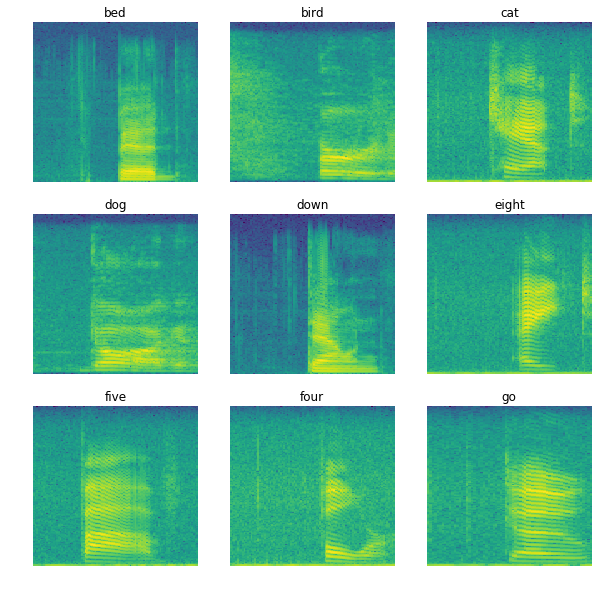

In [48]:
fig = plt.figure(figsize=(10,10))

# for each of the samples
for i, filepath in enumerate(sample_audio[:9]):
    # Make subplots
    plt.subplot(3,3,i+1)
    
    # pull the labels
    label = filepath.split('/')[-2]
    plt.title(label)
    
    # create spectogram
    samplerate, test_sound  = wavfile.read(filepath)
    _, spectrogram = log_specgram(test_sound, samplerate)
    
    plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.axis('off')

### 4.2 Spectograms within the same category, look at "five"


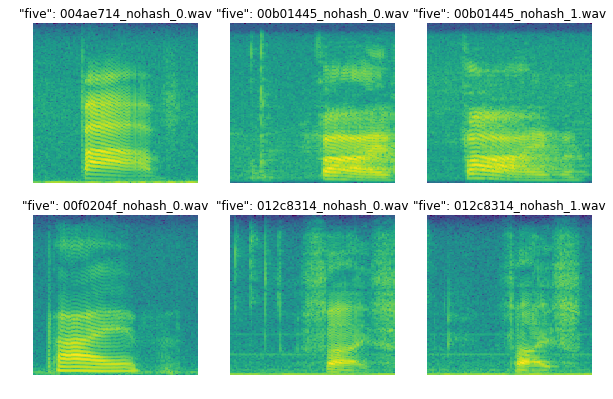

In [49]:
five_samples = [audio_path + 'five/' + y for y in os.listdir(audio_path + 'five/')[:6]]

fig = plt.figure(figsize=(10,10))

for i, filepath in enumerate(five_samples):
    # Make subplots
    plt.subplot(3,3,i+1)
    
    # pull the labels
    label = filepath.split('/')[-1]
    plt.title('"five": '+label)
    
    # create spectogram
    # create spectogram
    samplerate, test_sound  = wavfile.read(filepath)
    _, spectrogram = log_specgram(test_sound, samplerate)
    
    plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.axis('off')

## 5 Waveforms
### 5.1 Waveforms across different Words 

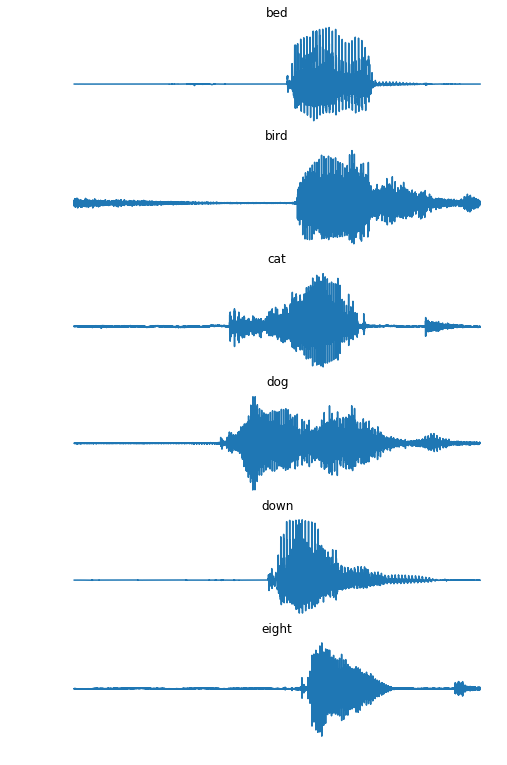

In [50]:
fig = plt.figure(figsize=(8,20))
for i, filepath in enumerate(sample_audio[:6]):
    plt.subplot(9,1,i+1)
    samplerate, test_sound  = wavfile.read(filepath)
    plt.title(filepath.split('/')[-2])
    plt.axis('off')
    plt.plot(test_sound)

### 5.2 Waveforms within the Same Word 

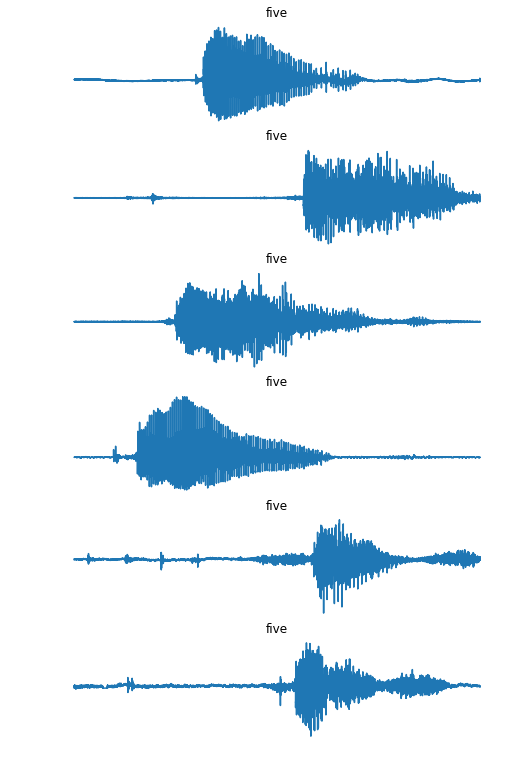

In [51]:
fig = plt.figure(figsize=(8,20))
for i, filepath in enumerate(five_samples):
    plt.subplot(9,1,i+1)
    samplerate, test_sound = wavfile.read(filepath)
    plt.title(filepath.split('/')[-2])
    plt.axis('off')
    plt.plot(test_sound)

## 6. Save Figures as images
#### Function: convert audio to spectogram images

In [52]:
def wav2img(wav_path, targetdir='', figsize=(4,4)):
    """
    takes in wave file path
    and the fig size. Default 4,4 will make images 288 x 288
    """

    fig = plt.figure(figsize=figsize)    
    # use soundfile library to read in the wave files
    samplerate, test_sound  = wavfile.read(filepath)
    _, spectrogram = log_specgram(test_sound, samplerate)
    
    ## create output path
    output_file = wav_path.split('/')[-1].split('.wav')[0]
    output_file = targetdir +'/'+ output_file
    #plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.imsave('%s.png' % output_file, spectrogram)
    plt.close()

#### Function: convert audio to waveform images

In [53]:
def wav2img_waveform(wav_path, targetdir='', figsize=(4,4)):
    samplerate,test_sound  = wavfile.read(sample_audio[0])
    fig = plt.figure(figsize=figsize)
    plt.plot(test_sound)
    plt.axis('off')
    output_file = wav_path.split('/')[-1].split('.wav')[0]
    output_file = targetdir +'/'+ output_file
    plt.savefig('%s.png' % output_file)
    plt.close()

In [55]:
for i, x in enumerate(subFolderList):
    print(i, ':', x)
    # get all the wave files
    all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
    for file in all_files[:10]:
        wav2img(audio_path + x + '/' + file, pict_Path + x)

0 : bed
1 : bird
2 : cat
3 : dog
4 : down
5 : eight
6 : five
7 : four
8 : go
9 : happy
10 : house
11 : left
12 : marvin
13 : nine
14 : no
15 : off
16 : on
17 : one
18 : right
19 : seven
20 : sheila
21 : six
22 : stop
23 : three
24 : tree
25 : two
26 : up
27 : wow
28 : yes
29 : zero
30 : _background_noise_


In [39]:
# # get all the wave files
# all_files = [y for y in os.listdir(test_audio_path + x) if '.wav' in y]
# for file in all_files:
#     wav2img(test_audio_path + x + '/' + file, test_pict_Path + x)